# CLDN16
[Hypomagnesemia-3 (HOMG3)](https://omim.org/entry/248250) is caused by homozygous or compound heterozygous mutation in the claudin-16 gene (CLDN16).

> [Godron A, et al. (2012)](https://pubmed.ncbi.nlm.nih.gov/22422540/) analyzed 32 individuals with CLD16 and CLD19 variants and concluded that
CLDN19 mutations may display more severe renal impairment than patients with CLDN16 mutations.

> [Radonsky V, et al. (2020)](https://pubmed.ncbi.nlm.nih.gov/32710267/) suggest a correlation with large CLDN16 deletions and severe phenotypes but do not provide narrative or statistical evidence.

In [1]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2024-08-13')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.9.1


### CLDN16
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for CLDN16.

In [2]:
gene_symbol = 'CLDN16'
mane_tx_id = 'NM_006580.4'
mane_protein_id = 'NP_006571.2' # claudin-16

In [3]:
from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.23") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
print(f'Loaded {len(phenopackets)} phenopackets')

from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets
cohort_creator = configure_caching_cohort_creator(hpo)

cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)

validation.summarize()

Loaded 51 phenopackets
Individuals Processed: 100%|██████████| 51/51 [00:30<00:00,  1.65individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

n,HPO Term
51,Nephrocalcinosis
45,Hypercalciuria
35,Hypermagnesiuria
33,Renal insufficiency
30,Elevated circulating parathyroid hormone level
30,Renal magnesium wasting
23,Polyuria
22,Polydipsia
21,Hypomagnesemia
17,Recurrent urinary tract infections


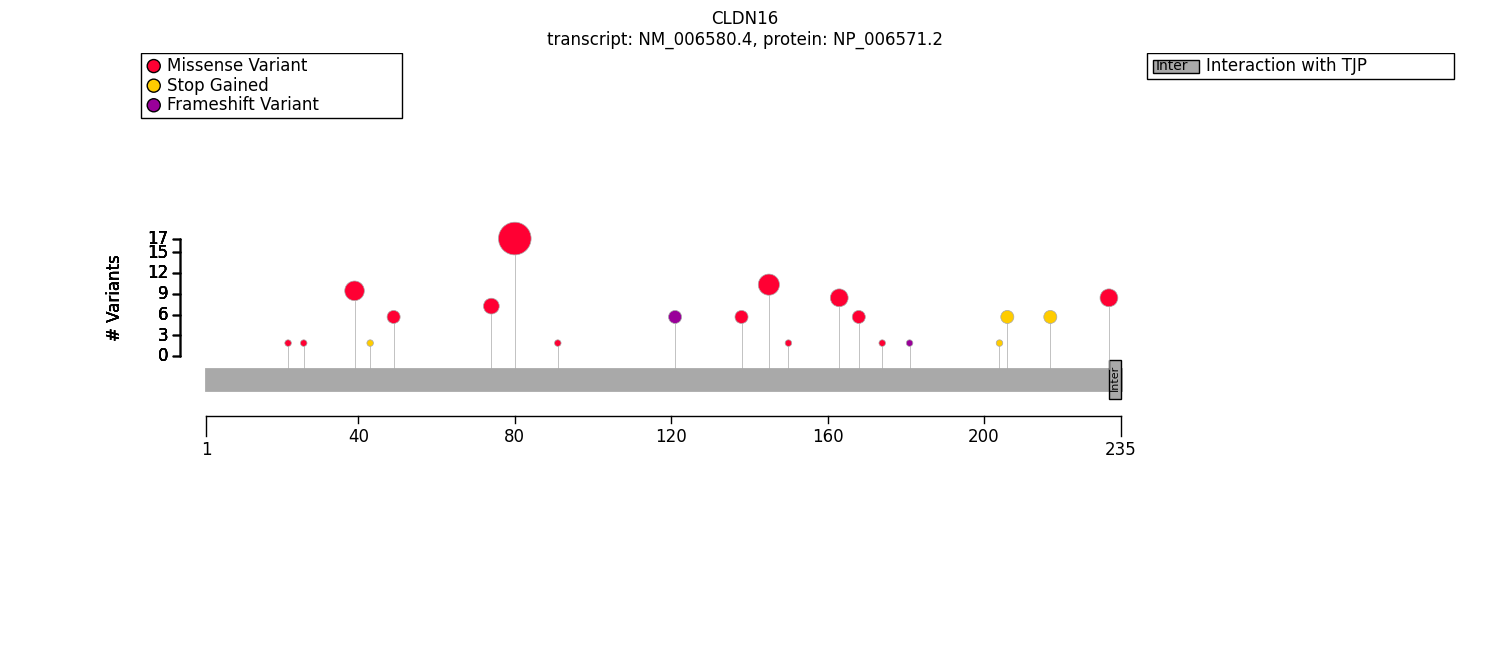

In [5]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)

# Could not use UniProt API, downloaded JSON file manually
protein_meta = ProteinMetadata.from_uniprot_json(
        protein_id=mane_protein_id,
        label="CLDN16",
        uniprot_json="Q9Y5I7.json",
        protein_length=235,
)


cldn16_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
cldn16_fig.tight_layout()

# Genotype-Phenotype Correlation (GPC) Analysis

In [6]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest 
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [8]:
from gpsea.analysis.clf import biallelic_classifier
from gpsea.analysis.predicate import variant_effect
from gpsea.model import VariantEffect
from gpsea.view import summarize_hpo_analysis

is_missense = variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)

missense_clf = biallelic_classifier(
    a_predicate=is_missense,
    b_predicate=~is_missense,
    a_label="missense",
    b_label="other",
    partitions = ({0,1}, {2,})
)

missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group                                       missense/missense OR missense/other  \
                                                                                 Count   
Stage 5 chronic kidney disease [HP:0003774]                                       2/39   
Nephrolithiasis [HP:0000787]                                                      7/30   
Failure to thrive [HP:0001508]                                                    7/24   
Abdominal pain [HP:0002027]                                                       8/24   
Recurrent urinary tract infections [HP:0000010]                                  14/30   
Hypercalciuria [HP:0002150]                                                      36/40   
Abnormality of urine calcium concentration [HP:...                               36/36   
Hypermagnesiuria [HP:0012608]                                                    28/30   
Abnormal urine magnesium concentration [HP:0012...                               30/30   
Elevated circulating parathyroid hormone level ...                               26/30   
Nephrocalcinosis [HP:0000121]                                                    41/41   
Abnormal renal morphology [HP:0012210]                                           41/41   
Abnormality of the kidney [HP:0000077]                                           41/41   
Renal insufficiency [HP:0000083]                                                 30/30   
Abnormal renal physiology [HP:0012211]                                           34/34   
Renal magnesium wasting [HP:0005567]                                             26/26   
Polyuria [HP:0000103]                                                            20/25   
Abnormal urine output [HP:0012590]                                               20/20   
Polydipsia [HP:0001959]                                                          19/24   
Abnormal drinking behavior [HP:0030082]                                          19/19   
Hypomagnesemia [HP:0002917]                                                      12/13   
Abnormal magnesium concentration [HP:0004921]                                    12/12   
Abnormal blood inorganic cation concentration [...                               12/12   

Allele group                                               other/other  \
                                                   Percent       Count   
Stage 5 chronic kidney disease [HP:0003774]             5%        5/10   
Nephrolithiasis [HP:0000787]                           23%         2/2   
Failure to thrive [HP:0001508]                         29%         1/1   
Abdominal pain [HP:0002027]                            33%         1/1   
Recurrent urinary tract infections [HP:0000010]        47%         3/4   
Hypercalciuria [HP:0002150]                            90%         9/9   
Abnormality of urine calcium concentration [HP:...    100%         9/9   
Hypermagnesiuria [HP:0012608]                          93%         7/7   
Abnormal urine magnesium concentration [HP:0012...    100%         8/8   
Elevated circulating parathyroid hormone level ...     87%         4/4   
Nephrocalcinosis [HP:0000121]                         100%       10/10   
Abnormal renal morphology [HP:0012210]                100%       10/10   
Abnormality of the kidney [HP:0000077]                100%       10/10   
Renal insufficiency [HP:0000083]                      100%       10/10   
Abnormal renal physiology [HP:0012211]                100%       10/10   
Renal magnesium wasting [HP:0005567]                  100%         4/4   
Polyuria [HP:0000103]                                  80%         3/3   
Abnormal urine output [HP:0012590]                    100%         3/3   
Polydipsia [HP:0001959]                                79%         3/3   
Abnormal drinking behavior [HP:0030082]               100%         3/3   
Hypomagnesemia [HP:0002917]                            92%         9/9   
Abnormal magnesium concentration [HP:0004921]  

In [10]:
from gpsea.analysis.predicate import variant_key

l81y = variant_key("3_190404787_190404787_G_T") # c.243G>T	p.Leu81Phe	
l81y_clf = biallelic_classifier(
    a_predicate=l81y,
    b_predicate=~l81y,
    a_label="Leu81Phe",
    b_label="other",
     partitions={(0,), (2,1)})
l81y_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=l81y_clf,
    pheno_clfs=pheno_clfs,
)

summarize_hpo_analysis(hpo=hpo, result=l81y_result)

Allele group                                       Leu81Phe/Leu81Phe          \
                                                               Count Percent   
Hyperuricosuria [HP:0003149]                                    5/13     38%   
Failure to thrive [HP:0001508]                                  6/13     46%   
Vomiting [HP:0002013]                                           6/13     46%   
Sterile pyuria [HP:0100586]                                     9/13     69%   
Hypermagnesiuria [HP:0012608]                                  13/13    100%   
Hypercalciuria [HP:0002150]                                    13/13    100%   
Polyuria [HP:0000103]                                          10/13     77%   
Polydipsia [HP:0001959]                                        10/13     77%   
Abnormality of urine calcium concentration [HP:...             13/13    100%   
Abnormal urine magnesium concentration [HP:0012...             13/13    100%   
Elevated circulating parathyroid hormone level ...             12/13     92%   
Nephrocalcinosis [HP:0000121]                                  13/13    100%   
Abnormal renal morphology [HP:0012210]                         13/13    100%   
Abnormality of the kidney [HP:0000077]                         13/13    100%   
Renal insufficiency [HP:0000083]                                 9/9    100%   
Abnormal renal physiology [HP:0012211]                         13/13    100%   
Renal magnesium wasting [HP:0005567]                           13/13    100%   
Recurrent urinary tract infections [HP:0000010]                 6/13     46%   
Abnormal urine output [HP:0012590]                             10/10    100%   
Abnormal drinking behavior [HP:0030082]                        10/10    100%   

Allele group                                       other/other OR Leu81Phe/other  \
                                                                           Count   
Hyperuricosuria [HP:0003149]                                                9/12   
Failure to thrive [HP:0001508]                                              2/12   
Vomiting [HP:0002013]                                                       2/11   
Sterile pyuria [HP:0100586]                                                 5/11   
Hypermagnesiuria [HP:0012608]                                              22/24   
Hypercalciuria [HP:0002150]                                                32/36   
Polyuria [HP:0000103]                                                      13/15   
Polydipsia [HP:0001959]                                                    12/14   
Abnormality of urine calcium concentration [HP:...                         32/32   
Abnormal urine magnesium concentration [HP:0012...                         25/25   
Elevated circulating parathyroid hormone level ...                         18/21   
Nephrocalcinosis [HP:0000121]                                              38/38   
Abnormal renal morphology [HP:0012210]                                     38/38   
Abnormality of the kidney [HP:0000077]                                     38/38   
Renal insufficiency [HP:0000083]                                           31/31   
Abnormal renal physiology [HP:0012211]                                     31/31   
Renal magnesium wasting [HP:0005567]                                       17/17   
Recurrent urinary tract infections [HP:0000010]                            11/21   
Abnormal urine output [HP:0012590]                                         13/13   
Abnormal drinking behavior [HP:0030082]                                    12/12   

Allele group                                                                   \
                                                   Percent Corrected p values   
Hyperuricosuria [HP:0003149]                           75%                1.0   
Failure to thrive [HP:0001508]                         17%                1.0   
Vomiting [HP:0002013]                                  18%        

In [11]:
from gpsea.analysis.clf import sex_classifier

mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo, mf_result)

Sex                                                FEMALE           MALE  \
                                                    Count Percent  Count   
Failure to thrive [HP:0001508]                       6/10     60%   2/15   
Abdominal pain [HP:0002027]                          6/10     60%   3/15   
Vomiting [HP:0002013]                                 5/9     56%   3/15   
Hypomagnesemia [HP:0002917]                           8/9     89%  12/12   
Hypermagnesiuria [HP:0012608]                       13/13    100%  21/23   
Polydipsia [HP:0001959]                              9/10     90%  13/17   
Polyuria [HP:0000103]                                9/10     90%  14/18   
Elevated circulating parathyroid hormone level ...  11/13     85%  19/21   
Hypercalciuria [HP:0002150]                         18/20     90%  26/28   
Abnormality of urine calcium concentration [HP:...  18/18    100%  26/26   
Abnormal urine magnesium concentration [HP:0012...  14/14    100%  23/23   
Nephrocalcinosis [HP:0000121]                       21/21    100%  29/29   
Abnormal renal morphology [HP:0012210]              21/21    100%  29/29   
Abnormality of the kidney [HP:0000077]              21/21    100%  29/29   
Renal insufficiency [HP:0000083]                    14/14    100%  25/25   
Abnormal renal physiology [HP:0012211]              16/16    100%  27/27   
Renal magnesium wasting [HP:0005567]                11/11    100%  19/19   
Sterile pyuria [HP:0100586]                           5/9     56%   9/15   
Recurrent urinary tract infections [HP:0000010]      6/12     50%  10/21   
Abnormal urine output [HP:0012590]                    9/9    100%  14/14   
Abnormal drinking behavior [HP:0030082]               9/9    100%  13/13   
Hyperuricosuria [HP:0003149]                          5/9     56%   9/16   

Sex                                                                            \
                                                   Percent Corrected p values   
Failure to thrive [HP:0001508]                         13%           0.616934   
Abdominal pain [HP:0002027]                            20%           0.729214   
Vomiting [HP:0002013]                                  20%           0.729214   
Hypomagnesemia [HP:0002917]                           100%           1.000000   
Hypermagnesiuria [HP:0012608]                          91%           1.000000   
Polydipsia [HP:0001959]                                76%           1.000000   
Polyuria [HP:0000103]                                  78%           1.000000   
Elevated circulating parathyroid hormone level ...     90%           1.000000   
Hypercalciuria [HP:0002150]                            93%           1.000000   
Abnormality of urine calcium concentration [HP:...    100%           1.000000   
Abnormal urine magnesium concentration [HP:0012...    100%           1.000000   
Nephrocalcinosis [HP:0000121]                         100%           1.000000   
Abnormal renal morphology [HP:0012210]                100%           1.000000   
Abnormality of the kidney [HP:0000077]                100%           1.000000   
Renal insufficiency [HP:0000083]                      100%           1.000000   
Abnormal renal physiology [HP:0012211]                100%           1.000000   
Renal magnesium wasting [HP:0005567]                  100%           1.000000   
Sterile pyuria [HP:0100586]                            60%           1.000000   
Recurrent urinary tract infections [HP:0000010]        48%           1.000000   
Abnormal urine output [HP:0012590]                    100%           1.000000   
Abnormal drinking behavior [HP:0030082]               100%           1.000000   
Hyperuricosuria [HP:0003149]                           56%           1.000000   

Sex                                                           
                                                    p values  
Failure to thrive [HP:0001508]                      0.028042  
Abdominal pain [HP:0002027]              

In [13]:
from gpsea.analysis.temporal.endpoint import disease_onset
hypomagnesemia_3 = "OMIM:248250"
hm3_onset = disease_onset(disease_id=hypomagnesemia_3)
from gpsea.analysis.temporal.stats import LogRankTest
survival_statistic = LogRankTest()
from gpsea.analysis.temporal import SurvivalAnalysis
survival_analysis = SurvivalAnalysis(
    statistic=survival_statistic,
)
missense_onset_result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_clf=missense_clf,
    endpoint=hm3_onset,
)
print(f"survival analysis p={missense_onset_result.pval:.5f}")


survival analysis p=0.33269


In [15]:
from gpsea.analysis.temporal.endpoint import hpo_onset
# Stage 5 chronic kidney disease HP:0003774
s5ckd = hpotk.TermId.from_curie("HP:0003774")
s5ckd_endpoint = hpo_onset(hpo=hpo, term_id=s5ckd)
s5ckd_onset_result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_clf=missense_clf,
    endpoint=s5ckd_endpoint,
)
print(f"survival analysis p={s5ckd_onset_result.pval:.5f}")

survival analysis p=0.03415


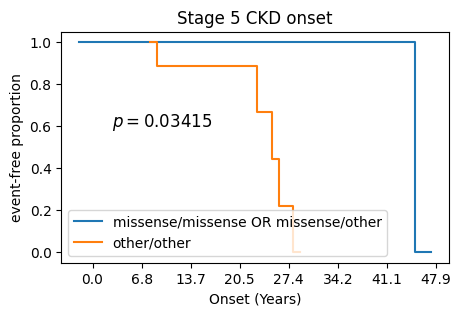

In [17]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

s5ckd_onset_fig, ax = plt.subplots(figsize=(5, 3))
s5ckd_onset_result.plot_kaplan_meier_curves(ax=ax)
def days_to_years(x, pos):
    return f"{x / 365.25:.1f}"


ax.xaxis.set_major_formatter(FuncFormatter(days_to_years))
ax.set_xlabel("Onset (Years)")
ax.set_ylabel("event-free proportion")
ax.set_title("Stage 5 CKD onset")
s = f"p={s5ckd_onset_result.pval:.5f}"
ax.text(x=1000, y=0.6, s=f"${s}$", fontsize=12);

# Summary

In [18]:
from gpseacs.report import  GPAnalysisResultSummary, GpseaAnalysisReport


m_results = (
    GPAnalysisResultSummary.from_mono(
        result=missense_onset_result
    ),
 GPAnalysisResultSummary.from_mono(
        result=s5ckd_onset_result
    ),
)

f_results =  (
    GPAnalysisResultSummary.from_multi(
        result=l81y_result,
    ), 
    GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=mf_result,
    ), 
)

report = GpseaAnalysisReport(
    name=gene_symbol,
    cohort=cohort,
    mono_results=m_results,
    fet_results=f_results,
    gene_symbol=gene_symbol,
    mane_tx_id=mane_tx_id,
    mane_protein_id=mane_protein_id,
)

In [19]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [20]:
summarizer.process_latex(report=report, protein_fig=cldn16_fig, stats_fig=s5ckd_onset_fig)

Figure saved to ../../supplement/img/CLDN16_protein_diagram-draft.pdf
Figure saved to ../../supplement/img/CLDN16_stats-draft.pdf
Output to ../../supplement/tex/CLDN16_summary_draft.tex
